In [1]:
%matplotlib inline
import numpy as np
import time
import copy
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as transforms
from datetime import datetime 
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.optim import lr_scheduler
from datetime import datetime 

In [2]:
import albumentations
from PIL import Image
from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

class ClassificationDataset:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        
        # ImageNet mean and std
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [
                albumentations.Normalize(
                    mean, std, max_pixel_value=255.0, always_apply=True)
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        targets = self.targets[item]
        accelerate_target = targets[2]
        steering_target = targets[0]
        if self.resize is not None:
            image = image.resize(
                resize, resample=Image.BILINEAR
            )

        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "accelerate_targets": torch.tensor(accelerate_target, dtype=torch.float),
            "steering_targets": torch.tensor(steering_target, dtype=torch.float)
        }

In [3]:
import glob
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
batch_size = 128
resize = (66,200)
DATA_DIR = "/home/gabriel/Área de Trabalho/mk7_dataset-roi"
image_files = glob.glob(os.path.join(DATA_DIR, "*.png"))
targets_orig = [eval(x.split("/")[-1][:-4].split("-hash_")[0]) for x in image_files] #list of lists containing the relevant list in the filename for each image

train_images,test_images,train_targets,test_targets = model_selection.train_test_split(
    image_files, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(
    image_paths=train_images,
    targets=train_targets,
    resize=resize
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True,
)

test_dataset = ClassificationDataset(
    image_paths=test_images,
    targets=test_targets,
    resize=resize,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False,
)

dataloaders = {
    "train": train_loader,
    "val": test_loader 
}

In [37]:
train_dataset.__getitem__(1)
#TODO: the item is correct with targets, now it must be passed as a batch properly in the train_loader

{'images': tensor([[[-1.4158, -1.4158, -1.4158,  ..., -0.9877, -0.8849, -0.8335],
          [-1.4158, -1.4158, -1.4158,  ..., -0.9877, -0.9020, -0.8335],
          [-1.4158, -1.4158, -1.4158,  ..., -0.9877, -0.9363, -0.9192],
          ...,
          [-0.7308, -0.7137, -0.5938,  ..., -0.3198, -0.4054, -0.5596],
          [-0.6623, -0.5938, -0.4739,  ..., -0.2342, -0.1828, -0.3027],
          [-0.5938, -0.5596, -0.4397,  ..., -0.1999, -0.0972, -0.0629]],
 
         [[ 0.9405,  0.9405,  0.9405,  ...,  1.1506,  1.2206,  1.3081],
          [ 0.9405,  0.9405,  0.9405,  ...,  1.1681,  1.2381,  1.3081],
          [ 0.9405,  0.9405,  0.9405,  ...,  1.1681,  1.2206,  1.2731],
          ...,
          [-0.6176, -0.6001, -0.4776,  ..., -0.1975, -0.2675, -0.4251],
          [-0.5301, -0.4601, -0.3550,  ..., -0.1099, -0.0574, -0.1800],
          [-0.4601, -0.4076, -0.3200,  ..., -0.0574,  0.0476,  0.0651]],
 
         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400

# Autonomous Steering model and training

In [4]:
class steering_model(nn.Module):
    #reference: https://arxiv.org/abs/1604.07316
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152,100),
            nn.Linear(100,50),
            nn.Linear(50,10),
            nn.Linear(10,1)
        )
    def forward(self,inputs):
        x = self.backbone(inputs)
        return x

In [5]:
lr=0.001
model = steering_model()
device = torch.device('cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
criterion = nn.MSELoss()

In [6]:
from tqdm.notebook import tqdm
num_epoches = 40
train_losses = []
val_losses = []
lowest_loss = 500.0

since = time.time()
for epoch in range(num_epoches):
    print('Epoch {}/{}'.format(epoch, num_epoches - 1))
    print('-' * 10)
    best_model_wts = copy.deepcopy(model.state_dict())
    running_loss = 0.0
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for inputs in tqdm(dataloaders[phase]):
            # unpack data in train_loader
            batch_images = inputs["images"]
            acc_targets = inputs["accelerate_targets"]
            steer_targets = inputs["steering_targets"]

            # adds dimensions to convert into single row tensor
            #acc_targets =  torch.unsqueeze(acc_targets, 1)
            steer_targets =  torch.unsqueeze(steer_targets, 1)

            # insert data in cpu or gpu
            batch_images.to(device)
            #acc_targets.to(device)
            steer_targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                #print(phase == 'train')
                steer_out = model(batch_images)
                #acc_loss = accelerate_loss(acc_out,acc_targets)
                #steer_loss = steering_loss(steer_out,steer_targets)
                loss = criterion(steer_out,steer_targets)

            if phase== "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.item() # batch_size
            
        epoch_loss = running_loss / len(dataloaders[phase]) * batch_size
        
        if phase == "train":
            train_losses.append(epoch_loss)
            scheduler.step()
        else:
            if epoch_loss < lowest_loss:
                lowest_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = f'./mk7-model-roi-checkpoint-epoche-{epoch}.pth'
                torch.save(model.state_dict(), PATH)
            val_losses.append(epoch_loss)

        print(f"{datetime.now().time().replace(microsecond=0)} - Loss for {phase}: {epoch_loss}")
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
model.load_state_dict(best_model_wts)
PATH = './mk7-model-roi.pth'
torch.save(model.state_dict(), PATH)

Epoch 0/39
----------



22:45:34 - Loss for train: 23.818055507748625



22:45:52 - Loss for val: 222.32876434326172
Epoch 1/39
----------



22:46:26 - Loss for train: 14.62086027722026



22:46:29 - Loss for val: 137.84904352823892
Epoch 2/39
----------



22:47:03 - Loss for train: 10.977350782054339



22:47:07 - Loss for val: 105.33591527938843
Epoch 3/39
----------



22:47:41 - Loss for train: 9.685408540474352



22:47:45 - Loss for val: 93.61692152023315
Epoch 4/39
----------



22:48:19 - Loss for train: 8.438175604324933



22:48:23 - Loss for val: 81.23995091120402
Epoch 5/39
----------



22:48:57 - Loss for train: 7.731148793715839



22:49:00 - Loss for val: 75.0352665424347
Epoch 6/39
----------



22:49:34 - Loss for train: 7.017628795416781



22:49:38 - Loss for val: 68.43141994476318
Epoch 7/39
----------



22:50:12 - Loss for train: 5.66070849211641



22:50:16 - Loss for val: 56.19107244809469
Epoch 8/39
----------



22:50:50 - Loss for train: 5.2658375510873725



22:50:54 - Loss for val: 52.63857517242432
Epoch 9/39
----------



22:51:29 - Loss for train: 5.074461419452993



22:51:32 - Loss for val: 50.959308528900145
Epoch 10/39
----------



22:52:07 - Loss for train: 4.953614515851634



22:52:10 - Loss for val: 49.82477099100749
Epoch 11/39
----------



22:52:45 - Loss for train: 4.767608773800754



22:52:49 - Loss for val: 48.27191128730774
Epoch 12/39
----------



22:53:23 - Loss for train: 4.631580415622208



22:53:27 - Loss for val: 47.0228809038798
Epoch 13/39
----------



22:54:01 - Loss for train: 4.489275902740715



22:54:05 - Loss for val: 45.74100817044576
Epoch 14/39
----------



22:54:39 - Loss for train: 4.23505581811417



22:54:43 - Loss for val: 43.51796056429545
Epoch 15/39
----------



22:55:17 - Loss for train: 4.197560439738193



22:55:21 - Loss for val: 43.18079620997111
Epoch 16/39
----------



22:55:55 - Loss for train: 4.176585962606031



22:55:59 - Loss for val: 43.003298330307004
Epoch 17/39
----------



22:56:33 - Loss for train: 4.161985669025155



22:56:37 - Loss for val: 42.87747152646383
Epoch 18/39
----------



22:57:11 - Loss for train: 4.143825616023337



22:57:15 - Loss for val: 42.714442571004234
Epoch 19/39
----------



22:57:50 - Loss for train: 4.128278726755187



22:57:54 - Loss for val: 42.58198364575704
Epoch 20/39
----------



22:58:28 - Loss for train: 4.108439545298731



22:58:31 - Loss for val: 42.41644296646118
Epoch 21/39
----------



22:59:06 - Loss for train: 4.077262752739958



22:59:10 - Loss for val: 42.14081466992696
Epoch 22/39
----------



22:59:45 - Loss for train: 4.076019449751507



22:59:48 - Loss for val: 42.12916328112284
Epoch 23/39
----------



23:00:23 - Loss for train: 4.075861596321875



23:00:27 - Loss for val: 42.12736029624939
Epoch 24/39
----------



23:01:01 - Loss for train: 4.070259345594303



23:01:05 - Loss for val: 42.078205331166586
Epoch 25/39
----------



23:01:39 - Loss for train: 4.06811589233635



23:01:43 - Loss for val: 42.05826656023661
Epoch 26/39
----------



23:02:18 - Loss for train: 4.0674396300500675



23:02:21 - Loss for val: 42.05327606201172
Epoch 27/39
----------



23:02:56 - Loss for train: 4.066321884938913



23:03:00 - Loss for val: 42.04442068735759
Epoch 28/39
----------



23:03:34 - Loss for train: 4.0623883092126185



23:03:38 - Loss for val: 42.01046744982401
Epoch 29/39
----------



23:04:12 - Loss for train: 4.060849138008532



23:04:16 - Loss for val: 41.99714101155599
Epoch 30/39
----------



23:04:51 - Loss for train: 4.061587644177814



23:04:55 - Loss for val: 42.00320507685343
Epoch 31/39
----------



23:05:29 - Loss for train: 4.063984083574872



23:05:33 - Loss for val: 42.02371404965719
Epoch 32/39
----------



23:06:07 - Loss for train: 4.060899889746378



23:06:11 - Loss for val: 41.997065258026126
Epoch 33/39
----------



23:06:45 - Loss for train: 4.060810321985289



23:06:49 - Loss for val: 41.996509329477945
Epoch 34/39
----------



23:07:23 - Loss for train: 4.0621327189512035



23:07:27 - Loss for val: 42.00761318206787
Epoch 35/39
----------



23:08:01 - Loss for train: 4.061788047006888



23:08:05 - Loss for val: 42.00463732083639
Epoch 36/39
----------



23:08:40 - Loss for train: 4.060370864794236



23:08:43 - Loss for val: 41.99246865908305
Epoch 37/39
----------



23:09:18 - Loss for train: 4.061503475026567



23:09:22 - Loss for val: 42.00221031506856
Epoch 38/39
----------



23:09:56 - Loss for train: 4.060764822849007



23:09:59 - Loss for val: 41.99582861264547
Epoch 39/39
----------



23:10:34 - Loss for train: 4.059939634892368



23:10:38 - Loss for val: 41.988718454043074
Training complete in 25m 54s


In [63]:
img = torch.rand((1, 3, 66, 200))
a = steering_model()
start = time.time()
result = a(img)
end = time.time()

In [64]:
end - start

0.002847909927368164

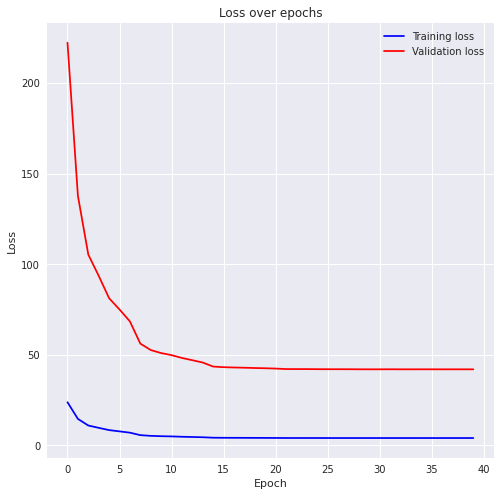

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losses(train_losses, valid_losses):
    plt.style.use('seaborn')
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    plt.style.use('default')
    plt.show()
    
plot_losses(train_losses, val_losses)

In [76]:
path = "/home/gabriel/Área de Trabalho/mk7_dataset/[0.0341796875, -0.06756591796875, 1, 0, 0]-hash_3a202463-d706-42f4-bb40-30bb5042a8ff.png"
image = np.array(cv2.imread(path))
image = Image.fromarray(np.uint8(image)).convert('RGB')
#image = Image.open(path).convert("RGB")
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
aug = albumentations.Compose(
            [
                albumentations.Normalize(
                    mean, std, max_pixel_value=255.0, always_apply=True)
            ]
        )
image = image.resize(
    resize, resample=Image.BILINEAR
)

image = np.array(image)
augmented = aug(image=image)
image = augmented["image"]
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = image[None,:,:,:]
image.shape

(1, 3, 200, 66)

(array([ 1918.,   502.,   491.,   489.,   809., 11670.,   441.,   383.,
          366.,  1260.]),
 array([-1.00000000e+00, -8.00003052e-01, -6.00006104e-01, -4.00009155e-01,
        -2.00012207e-01, -1.52587891e-05,  1.99981689e-01,  3.99978638e-01,
         5.99975586e-01,  7.99972534e-01,  9.99969482e-01]),
 <BarContainer object of 10 artists>)

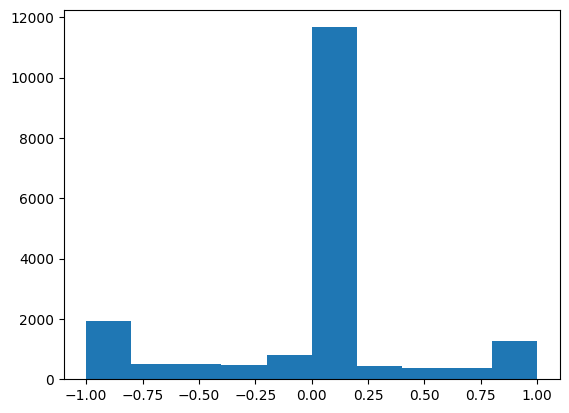

In [10]:
steering_data = [x[0] for x in targets_orig]
steering_data
plt.hist(steering_data)